In [2]:
import argparse
from pathlib import Path
import numpy as np
import pickle
import string
from functools import partial
from sklearn.metrics.pairwise import cosine_similarity

from mist import utils

import matplotlib.pyplot as plt
import seaborn as sns
from mist.utils.plot_utils import *

from scipy.stats import pearsonr

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='sans serif')
# sns.set_palette(['#9e0059', '#6da7de', '#ee266d', '#dee000', '#eb861e'])
sns.set_context('paper', font_scale=1.3)

In [4]:
METRIC_POOL_TUPLES = [("Cosine", "spectra"),
                      ("LL", "spectra"),
                      ("LL", "bit")]

In [5]:
def ll(pred, targ):
    """nll.

    Args:
        pred:
        targ:
    """
    log = partial(utils.clamped_log_np, _min=-5)
    ll = targ * log(pred) + (1 - targ) * log(1 - pred)
    return ll


def cos_sim(pred, targ):
    """nll.

    Args:
        pred:
        targ:
    """
    pred

    sim = cosine_similarity(pred, targ)
    sim = np.diag(sim)
    return sim[:, None]


def tani(pred, targ):
    """tani.

    Args:
        pred:
        targ:
    """
    pred = np.copy(pred)
    above_thresh = pred >= 0.5
    pred[above_thresh] = 1.0
    pred[~above_thresh] = 0.0

    pred, targ = pred.astype(bool), targ.astype(bool)
    denom = np.logical_or(pred, targ).sum(-1)
    num = np.logical_and(pred, targ).sum(-1)
    res = num / denom
    return res[:, None]


def get_metric(metric):
    """get_metric.

    Args:
        metric:
    """
    """get_metric.

    Args:
        metric:
    """
    return {
        "LL": ll,
        "Cosine": cos_sim,
        "Tani": tani,
    }[metric]

In [6]:
def compute_fp_results(pred_file, baseline_file, model_name, baseline_name, metric, pool_method):
    # Get preds and sort
    fp_preds = pickle.load(open(pred_file, "rb"))
    a_names, a_preds, a_targs = fp_preds["names"], fp_preds["preds"], fp_preds["targs"]
    a_names, a_preds, a_targs = np.array(a_names), np.asarray(a_preds), np.asarray(a_targs)
    #print(a_preds[0], a_targs[0])
    #a_names = np.array(a_names)
    a_keep_set = set(a_names)

    # Get baselines
    b_preds = pickle.load(open(baseline_file, "rb"))
    b_names, b_preds, b_targs = b_preds["names"], b_preds["preds"], b_preds["targs"]
    b_names, b_preds, b_targs = np.array(b_names), np.array(b_preds), np.array(b_targs)
    b_keep_set = set(b_names)

    # Get set overlap of names
    keep_set = b_keep_set.intersection(a_keep_set)

    # Filter both down to overlap
    b_keep = [i in keep_set for i in b_names]
    b_names, b_preds, b_targs = b_names[b_keep], b_preds[b_keep], b_targs[b_keep]

    a_keep = [i in keep_set for i in a_names]
    a_names, a_preds, a_targs = a_names[a_keep], a_preds[a_keep], a_targs[a_keep]

    a_sort = np.argsort(a_names)
    b_sort = np.argsort(b_names)
    a_names, a_preds, a_targs = a_names[a_sort], a_preds[a_sort], a_targs[a_sort]
    b_names, b_preds, b_targs = b_names[b_sort], b_preds[b_sort], b_targs[b_sort]

    print(a_targs.shape, b_targs.shape)
    
    assert np.all(a_targs == b_targs)

    # Next compute matrix predictions
    # Start with likelihoods
    val_fn = get_metric(metric)
    a_res = val_fn(a_preds, a_targs)
    b_res = val_fn(b_preds, b_targs)

    print(f"{model_name} Mean values: {a_res.mean()}")
    print(f"{baseline_name} Mean values: {b_res.mean()}")

    if pool_method == "spectra":
        a_res = a_res.mean(1)
        b_res = b_res.mean(1)
    elif pool_method == "bit":
        a_res = a_res.mean(0)
        b_res = b_res.mean(0)

    return a_res, b_res

In [7]:
def plot_scatter(fp_pred_file, fp_base_file, fp_model_name, fp_base_name, save_name):    
    width = 7
    height = width / 1.618

    fig, axes = plt.subplots(1, 3, figsize=(width * 2.2, height))

    for i, (ax, (metric, pool_method)) in enumerate(zip(axes, METRIC_POOL_TUPLES)):
        a_res, b_res = compute_fp_results(fp_pred_file, fp_base_file, fp_model_name, fp_base_name, metric, pool_method)

        ax.set_box_aspect(1)
        
        # set plot title
        metric_title = {
            "LL": "Log Likelihood",
            "Cosine": "Cosine Similarity",
            "Tani": "Tanimoto Similarity",
        }.get(metric)
        pool_title = {"bit": "(fingerprint bits)", "spectra": "(spectra)"}.get(pool_method)
        top_title = f"{metric_title}\n{pool_title}"
        ax.set_title(top_title)

        sns.kdeplot(
                x=a_res.squeeze(),
                y=b_res.squeeze(),
                fill=True,
                bw_adjust=0.6,
                cmap="Oranges",
                ax=ax,
                cbar=False,
                cut=0,
                levels=8
            )
        
        a_higher = (a_res - b_res) > 0
        b_higher = (b_res - a_res) > 0
        num_a_higher = a_higher.sum()
        num_b_higher = b_higher.sum()
        c1 = ["red", "red"]
        ax.scatter(
            a_res[a_higher],
            b_res[a_higher],
            marker="X",
            s=0.2,
            alpha=0.2,  # 0.2,
            #c=c1[0],
            c="orange"
        )
        ax.scatter(
            a_res[b_higher],
            b_res[b_higher],
            marker="X",
            s=0.2,
            alpha=0.2,  # 0.2,
            #c=c1[1],
            c="orange"
        )

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        lb = np.min([xlim[0], ylim[0]])
        ub = np.max([xlim[1], ylim[1]])

        ax.plot(
            np.linspace(-100, 100, 100),
            np.linspace(-100, 100, 100),
            c="black",
            linewidth=0.7,
            linestyle="--",
        )

        # Subset to 95th percentile for zoom
        min_el = [min(i, j) for i, j in zip(a_res.squeeze(), b_res.squeeze())]
        max_el = [min(i, j) for i, j in zip(a_res.squeeze(), b_res.squeeze())]

        lb, ub = np.percentile(min_el, 1), np.percentile(max_el, 99)

        if metric == "LL":
            ax.set_xlim([lb, 0])
            ax.set_ylim([lb, 0])
        elif metric == "Cosine":
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
        elif metric == "Tani":
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])

        ax.set_xlabel(f"{fp_model_name}")

        print(f"{fp_model_name} is higher: {num_a_higher}")
        print(f"{fp_base_name} is higher: {num_b_higher}")
        left, width = 0, 0.5  # .25, 0.25 #0.5
        bottom, height = 0.1, 0.5
        right = left + width
        top = bottom + height

        corr, _ = pearsonr(a_res, b_res)
        ax.text(
            right,
            bottom,
            f"correlation = {corr : 0.2f}".expandtabs(),
            transform=ax.transAxes,
            # fontsize=15,
        )

        ax.text(-0.1, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, size=15, weight='bold')
        
    axes[0].set_ylabel(f"{fp_base_name}")

    plt.savefig(save_name, format="pdf", bbox_inches="tight", dpi=600, transparent=True)

(819, 4096) (819, 4096)
MIST retrain Mean values: 0.682938451151743
MIST public Mean values: 0.6992460916943783
MIST retrain is higher: 353
MIST public is higher: 466
(819, 4096) (819, 4096)
MIST retrain Mean values: -0.02391689456999302
MIST public Mean values: -0.024643290787935257
MIST retrain is higher: 500
MIST public is higher: 319
(819, 4096) (819, 4096)
MIST retrain Mean values: -0.02391689456999302
MIST public Mean values: -0.024643290787935257
MIST retrain is higher: 2015
MIST public is higher: 2081


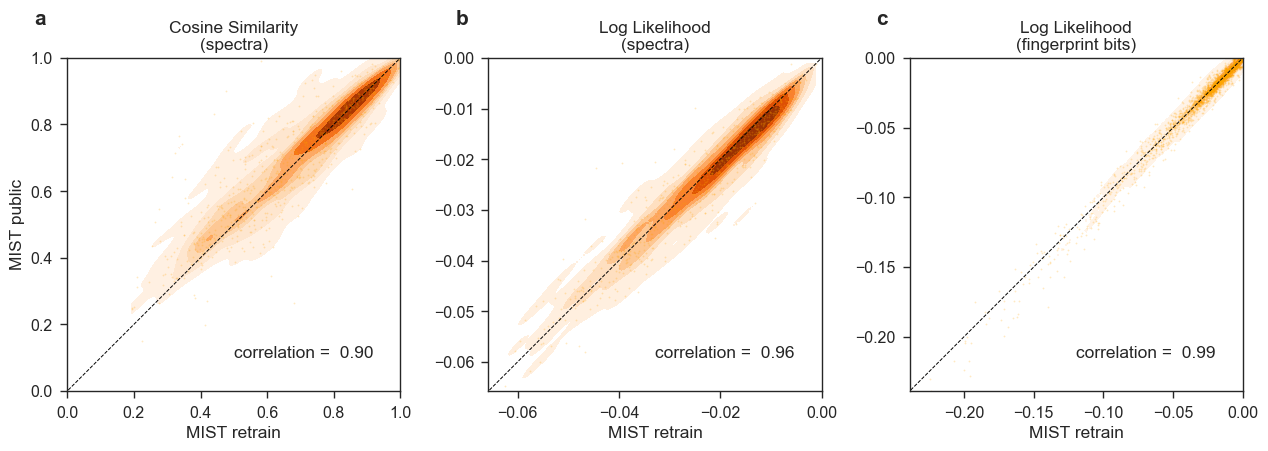

In [9]:
# canopus scatter plots
fp_pred_file = "../../results/retrained_models/mist_fp_model_aug/preds_canopus_train_public/out_preds_single/merged_fp_preds.p"
fp_base_file = "../../pretrained_models/mist_canopus_public/fp_model/preds_canopus_train_public/out_preds_single/merged_fp_preds.p"
fp_model_name = "MIST retrain"
fp_base_name = "MIST public"

save_name = "../../results/reproducibility/fp_scatter/scatter_plots.pdf"

plot_scatter(fp_pred_file, fp_base_file, fp_model_name, fp_base_name, save_name)